In [1]:
from collections import defaultdict
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scripts.eas_lists import OsoData
from scripts.oso_db import execute_query
from scripts.processing import (
    github_event_processor, 
    github_active_developers, 
    github_repos_analysis,
    github_network_graph
)

from visualizations.contribution_heatmap import contribution_heatmap
from visualizations.network_graph import network_graph
from visualizations.stacked_area import activity_plot
from visualizations.venn_diagram import venn3_diagram


DPI = 144 # high res viz; looks best at 300
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = DPI
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Fetch / update data

In [6]:
DATA_DIR  = "data/RPGF3/"
DATA_PATH = DATA_DIR + "2023-11_06_RPGF3_cleaned_applicant_data.json"

RPGF2_DATE = '2023-04-01'
END_DATE = '2023-10-01'

In [7]:
oso = OsoData(DATA_PATH)
slugs = oso.get_project_slugs()

Loaded 311 OSS projects from data/RPGF3/2023-11_06_RPGF3_cleaned_applicant_data.json.
Identified 311 unique slugs.


In [11]:
# create a mapping of projects to collections
query = """
    SELECT p."slug", c."slug" 
    FROM project p 
    JOIN collection_projects_project cpp ON p."id" = cpp."projectId"
    JOIN collection c ON cpp."collectionId" = c."id"
    """
result = execute_query(query, col_names=False)
cpp = {k: sorted([v for v, key in result if key == k]) for k in set(key for _, key in result)}

# Visualize dataset coverage

Total projects: 366


(<Figure size 1440x1440 with 1 Axes>, <AxesSubplot:>)

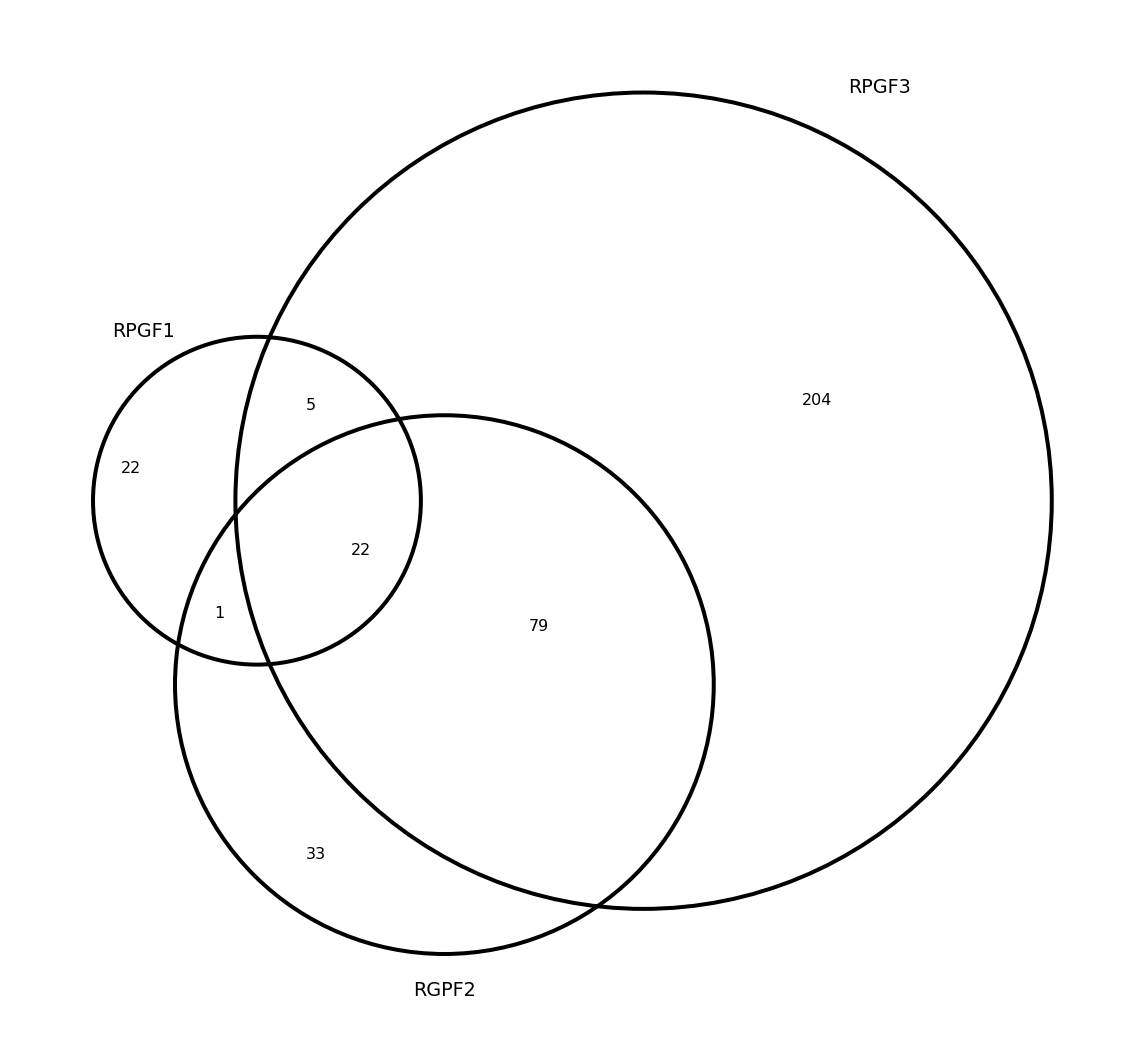

In [17]:
collection_slugs = ["op-rpgf1", "op-rpgf2", "op-rpgf3"]
total_projects = len(set([p for c,ps in cpp.items() if c in collection_slugs for p in ps]))
print("Total projects:", total_projects)

venn3_diagram(
    [set(ps) for c,ps in cpp.items() if c in collection_slugs], 
    ["RPGF1", "RPGF3", "RGPF2"]
)

# Basic analysis

In [8]:
# first commit
df[df['event_type'] == 'COMMIT_CODE']['event_time'].min()

'2015-01-01 00:12:08+00:00'

In [9]:
# total commits
len(df[df['event_type'] == 'COMMIT_CODE'])

983315

<AxesSubplot:xlabel='month'>

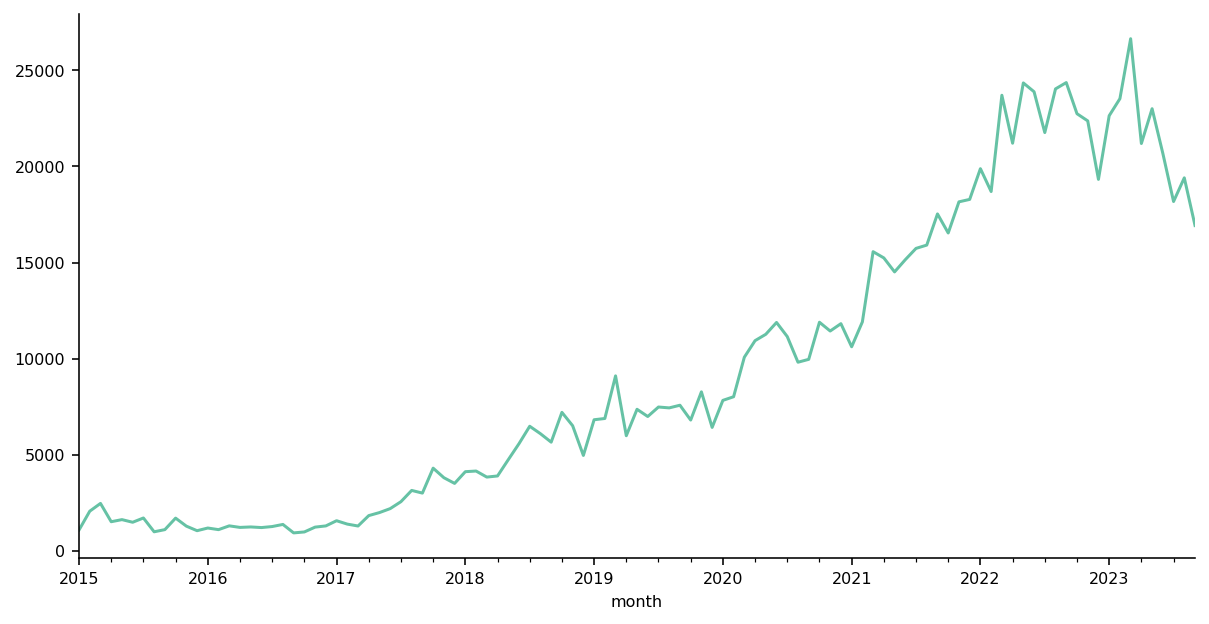

In [10]:
df[df['event_type'] == 'COMMIT_CODE'].groupby('month')['event_time'].count().plot()

In [11]:
# total devs
len(df[df['event_type'] == 'COMMIT_CODE']['contributor_name'].unique())

8918

In [12]:
# original repos
len(df['github_repo'].unique())

7235

# Aggregate trends

<AxesSubplot:ylabel='Developers'>

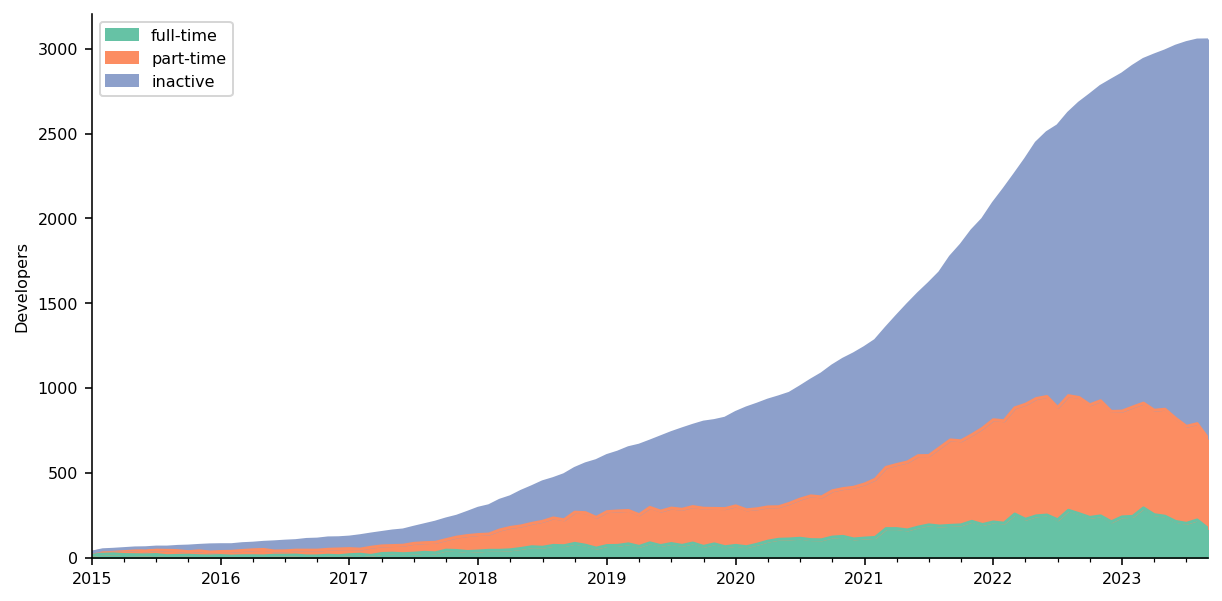

In [13]:
DEVS_EVENTS = ['COMMIT_CODE']
devs = github_active_developers(df, event_filters=DEVS_EVENTS, min_days=10)
devs.T.plot(kind='area', ylabel='Developers', xlabel="")

<AxesSubplot:ylabel='Developers'>

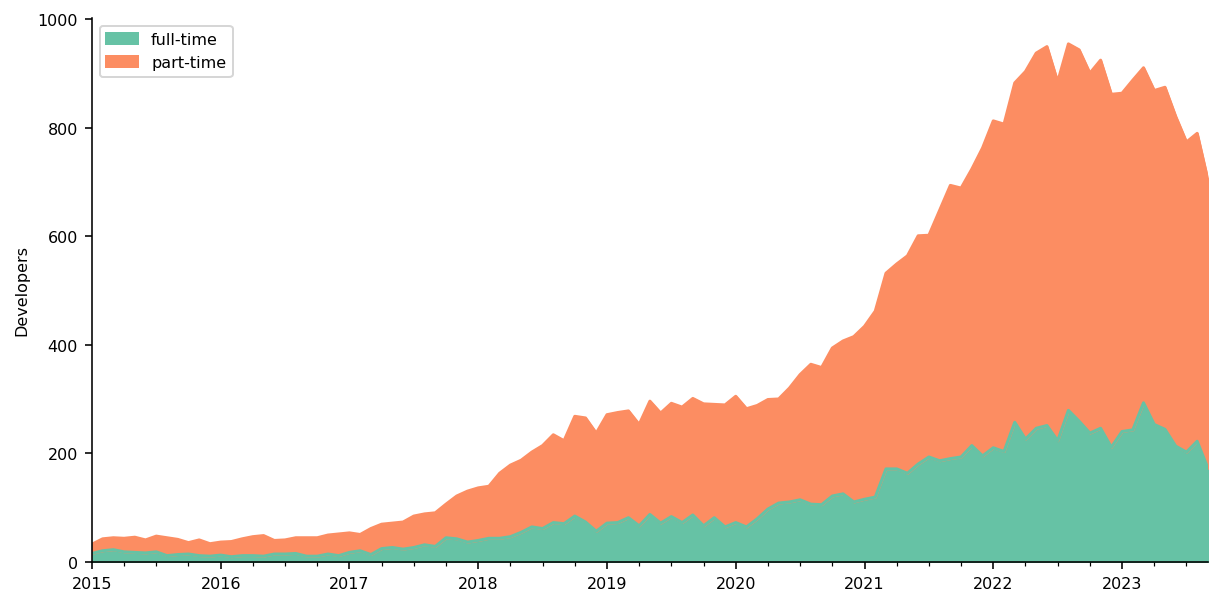

In [14]:
devs.T[['full-time', 'part-time']].plot(kind='area', ylabel='Developers', xlabel="")

<AxesSubplot:ylabel='Maintainers'>

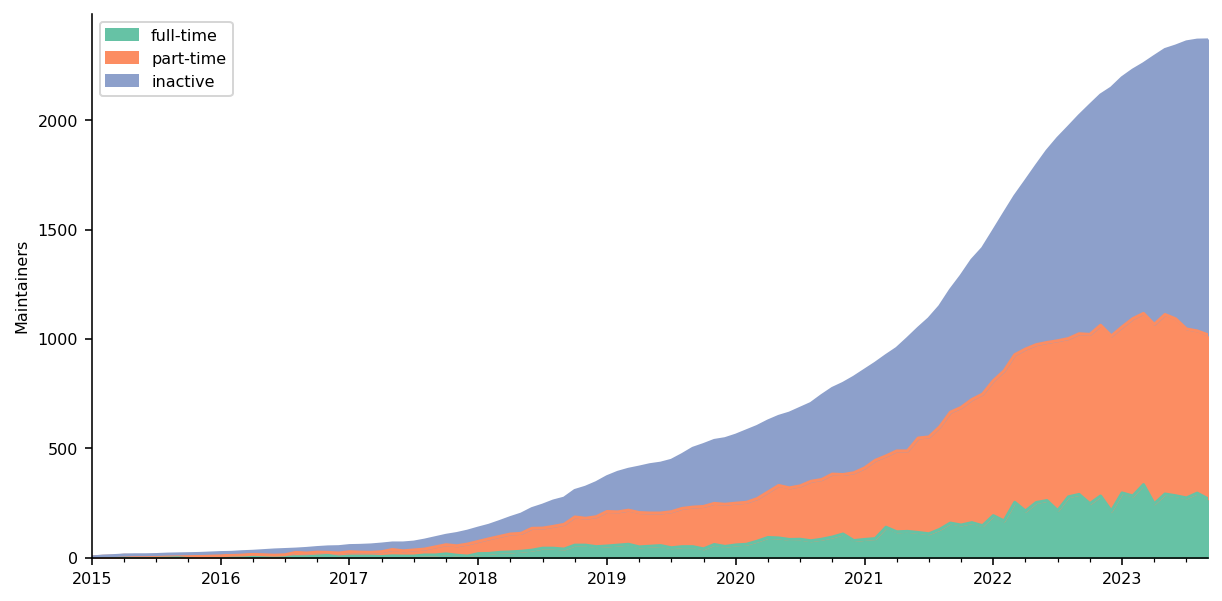

In [15]:
MAINTAINERS_EVENTS = ['PULL_REQUEST_APPROVED', 'ISSUE_CLOSED']
maintainers = github_active_developers(df, event_filters=MAINTAINERS_EVENTS, min_days=10)
maintainers.T.plot(kind='area', ylabel='Maintainers', xlabel="")

<AxesSubplot:ylabel='Contributors'>

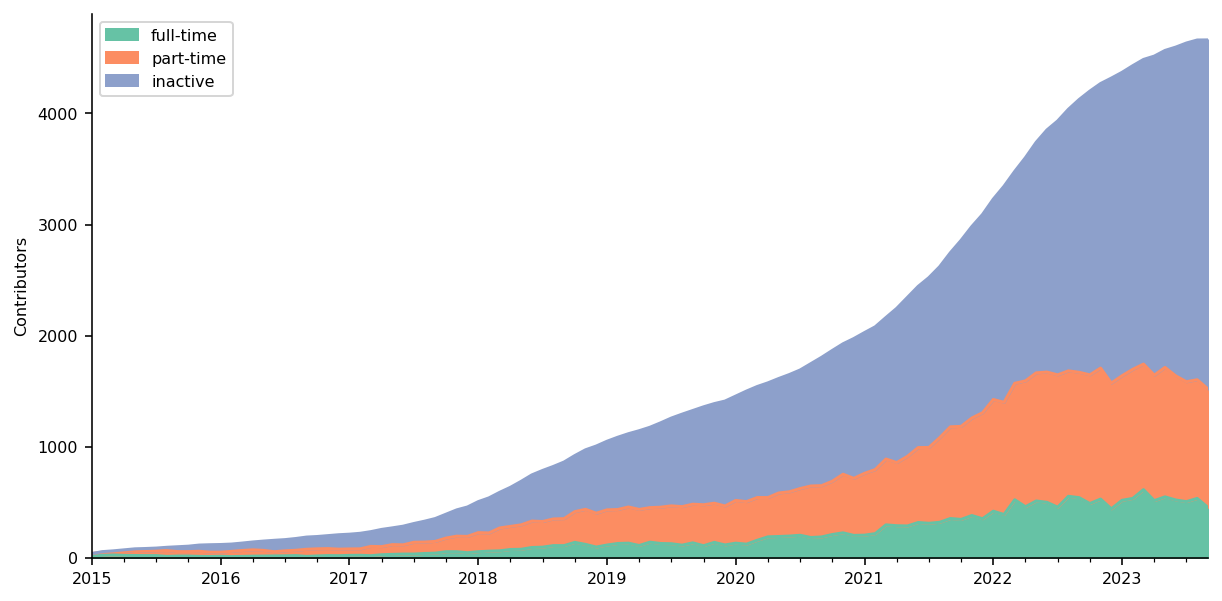

In [16]:
CONTRIBUTORS_EVENTS = ['COMMIT_CODE', 'PULL_REQUEST_APPROVED', 'ISSUE_CREATED']
contributors = github_active_developers(df, event_filters=CONTRIBUTORS_EVENTS, min_days=10)
contributors.T.plot(kind='area', ylabel='Contributors', xlabel="")

<AxesSubplot:ylabel='Contributors'>

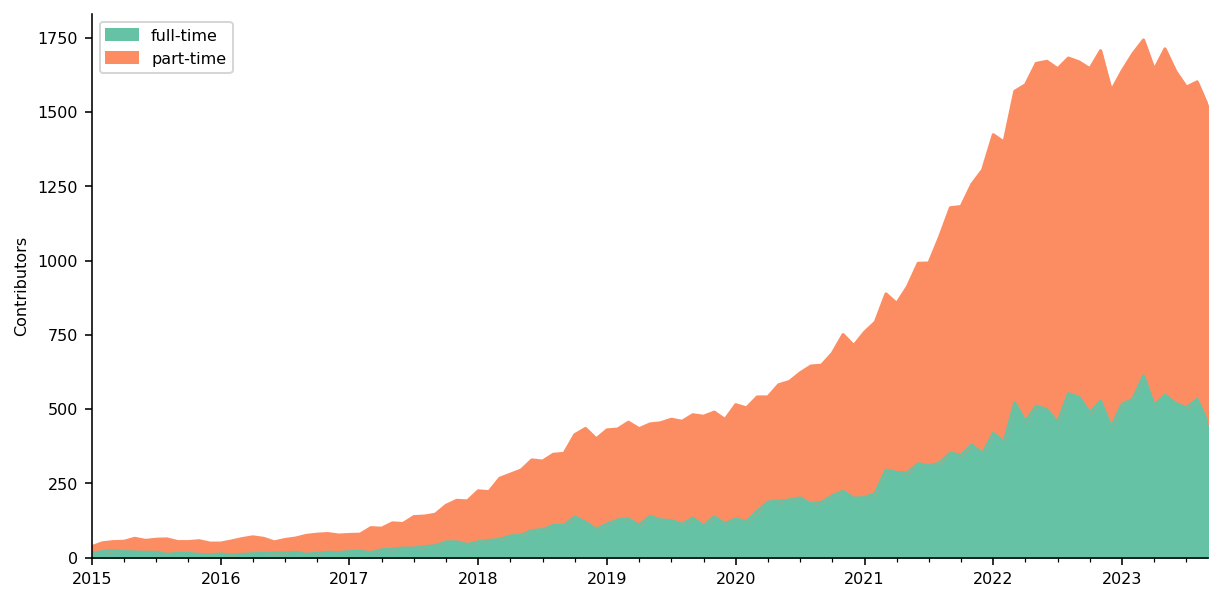

In [17]:
contributors.T[['full-time', 'part-time']].plot(kind='area', ylabel='Contributors', xlabel="")

(<Figure size 3000x1500 with 1 Axes>,
 <AxesSubplot:ylabel='Total Contributions'>)

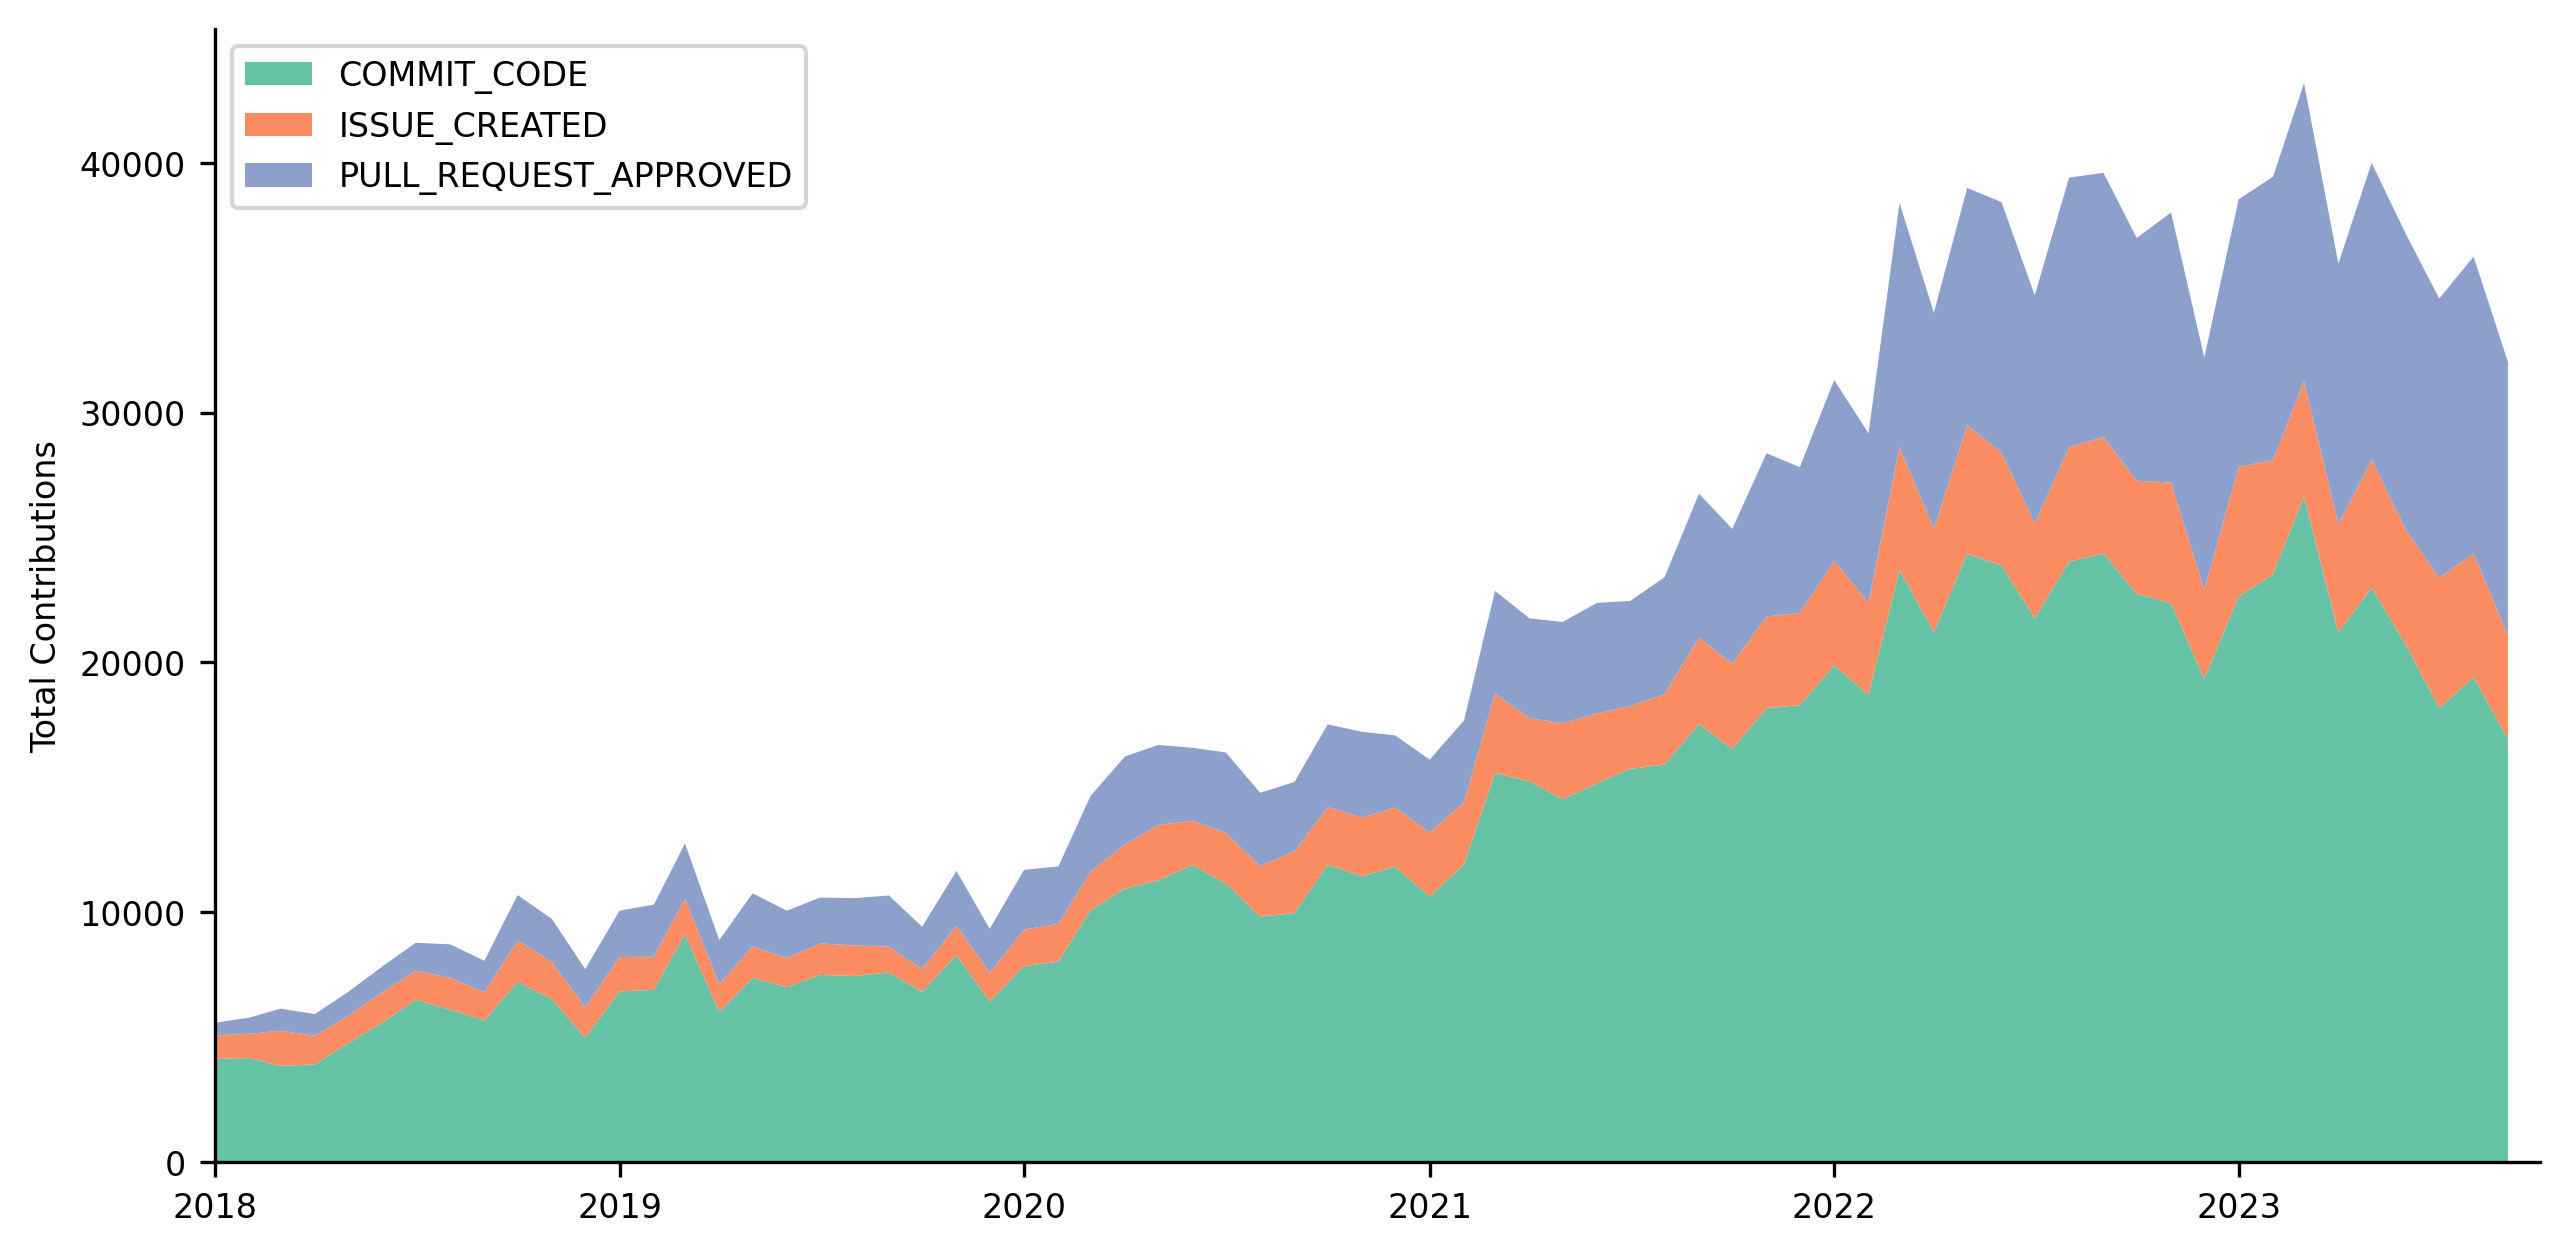

In [18]:
activity_plot(
    df, 
    grouper_col='event_type', 
    date_col='month', 
    start_date='2018-01-01',
    end_date='2023-09-30',
    filter_vals=CONTRIBUTORS_EVENTS
)

# Repo analysis

In [19]:
rdf = github_repos_analysis(df)    
rdf.sort_values(by='stars_count', ascending=False).head(10)

,,num_repos,first_date,last_date,stars_count,days_since_first_commit,days_since_last_commit,last_commit_category,stars_category,project_age
project_slug,project_name,,,,,,,,,
go-ethereum,geth,1,2015-01-01,2023-09-30,43474.0,3194,0,active,very popular,> 4 years old
openzeppelin,OpenZeppelin,84,2016-08-01,2023-09-30,26405.0,2616,0,active,very popular,> 4 years old
solidity,Solidity,1,2015-01-01,2023-09-30,20937.0,3194,0,active,very popular,> 4 years old
metamask,Metamask,177,2015-01-05,2023-09-30,16196.0,3190,0,active,very popular,> 4 years old
uniswap,Uniswap,58,2017-11-15,2023-09-30,14679.0,2145,0,active,very popular,> 4 years old
ethers-io,ethers.js,29,2016-05-03,2023-09-30,7475.0,2706,0,active,very popular,> 4 years old
foundry,Foundry,15,2021-09-05,2023-09-30,7322.0,755,0,active,very popular,2-4 years old
open-sea,OpenSea,36,2018-03-04,2023-09-30,6212.0,2036,0,active,very popular,> 4 years old
rainbow,Rainbow,21,2018-03-24,2023-09-30,5939.0,2016,0,active,very popular,> 4 years old


In [20]:
pd.crosstab(rdf['last_commit_category'], rdf['stars_category'])

stars_category,less popular,more popular,very popular
last_commit_category,,,
active,33,213,56
dormant,9,16,0
inactive,14,9,0


In [21]:
pd.crosstab(rdf['project_age'], rdf['stars_category'])

stars_category,less popular,more popular,very popular
project_age,,,
< 2 years,41,73,4
2-4 years old,12,104,15
> 4 years old,3,61,37


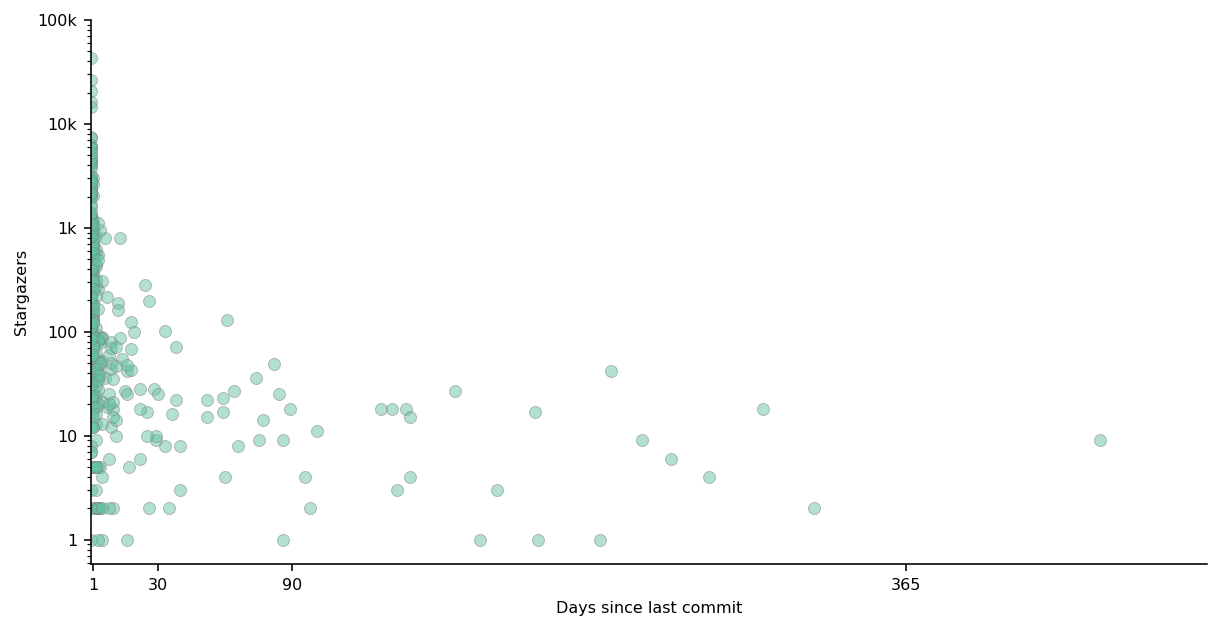

In [22]:
fig = sns.scatterplot(
    data=rdf,
    x='days_since_last_commit',
    y='stars_count',
    legend=False,
    alpha=.5,
    edgecolor='grey'
)
fig.set(
    yscale='log',  
    ylim=(0,100000), xlim=(0,500), 
    ylabel='Stargazers', xlabel='Days since last commit',
    xticks=[1,30,90,365],
    yticks=[1,10,100,1000,10000,100000],
    yticklabels=[1,10,100,"1k","10k","100k"]
)
sns.despine()

# Heatmapping

In [23]:
dff = df[df['event_type'].isin(CONTRIBUTORS_EVENTS)]

(<Figure size 3024x3744 with 1 Axes>, <AxesSubplot:>)

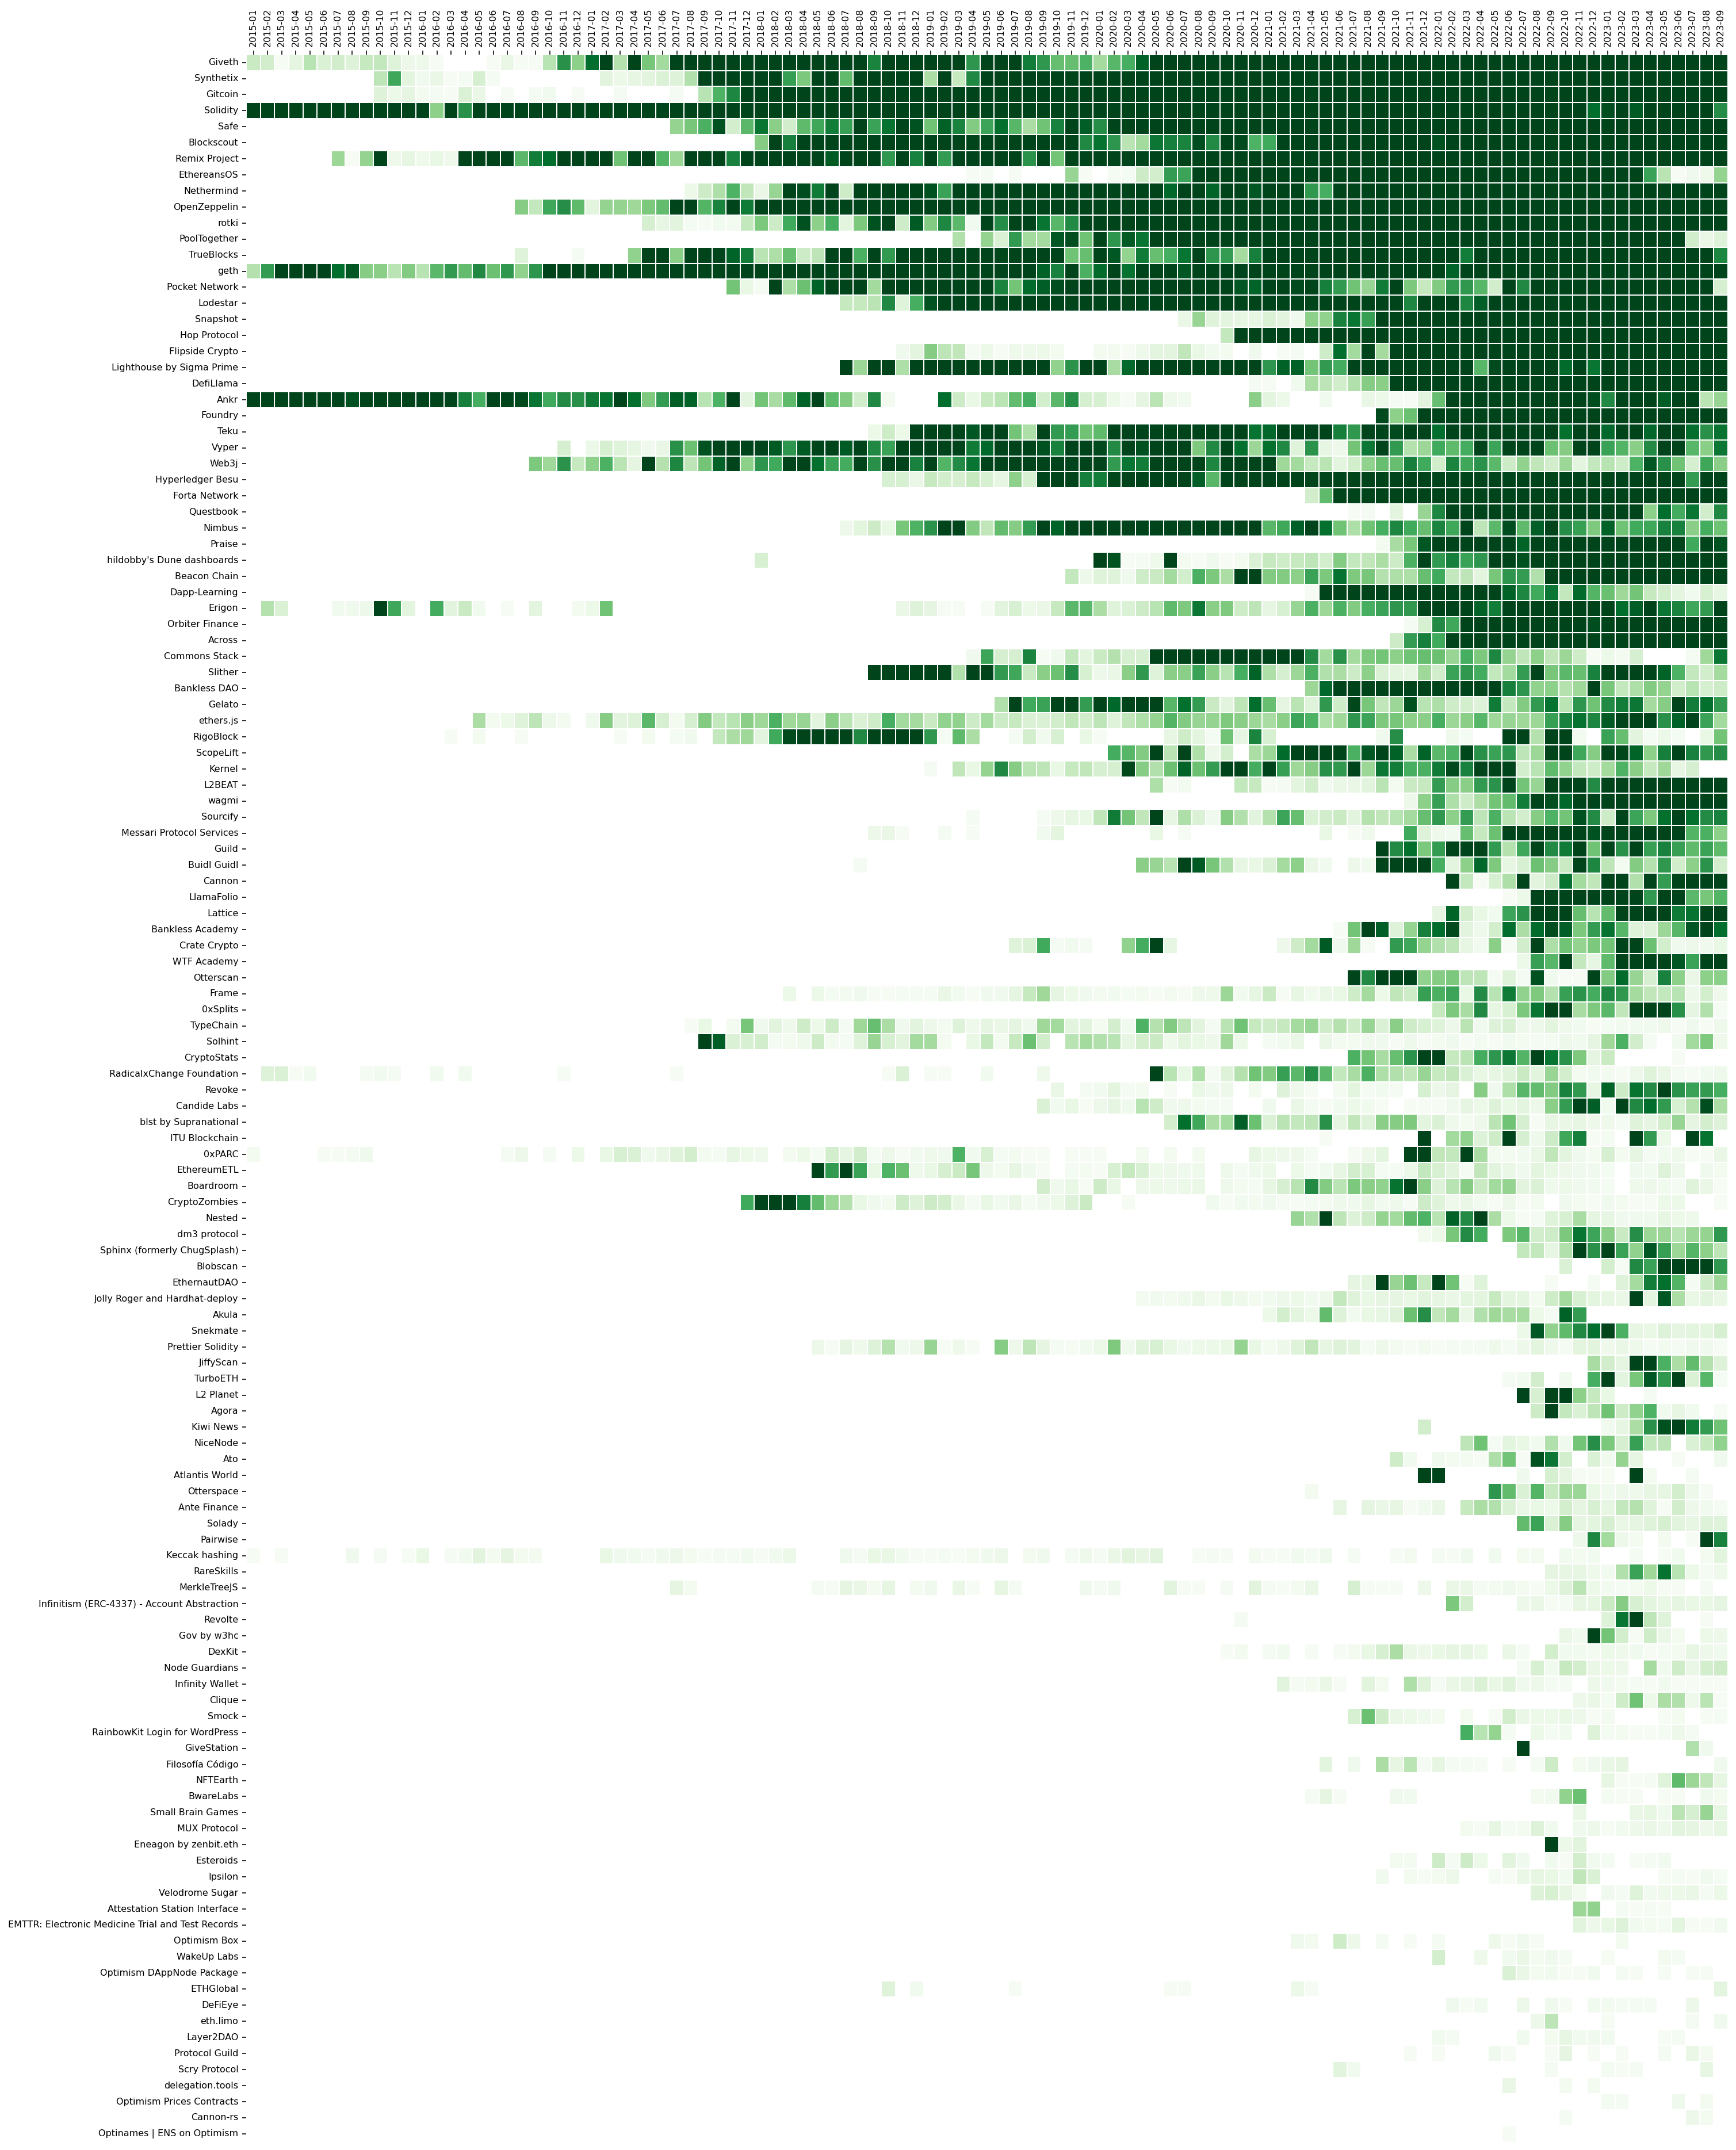

In [24]:
contribution_heatmap(
    dff[dff['project_slug'].isin(cpp['op-rpgf2'])],
    index_col='project_name',
    column_col='month',
    value_col='event_time',
    apply_groupby=True,
    vmax=100,
    sort_label_method='mean',
    dpi=DPI
)

(<Figure size 3024x4896 with 1 Axes>, <AxesSubplot:>)

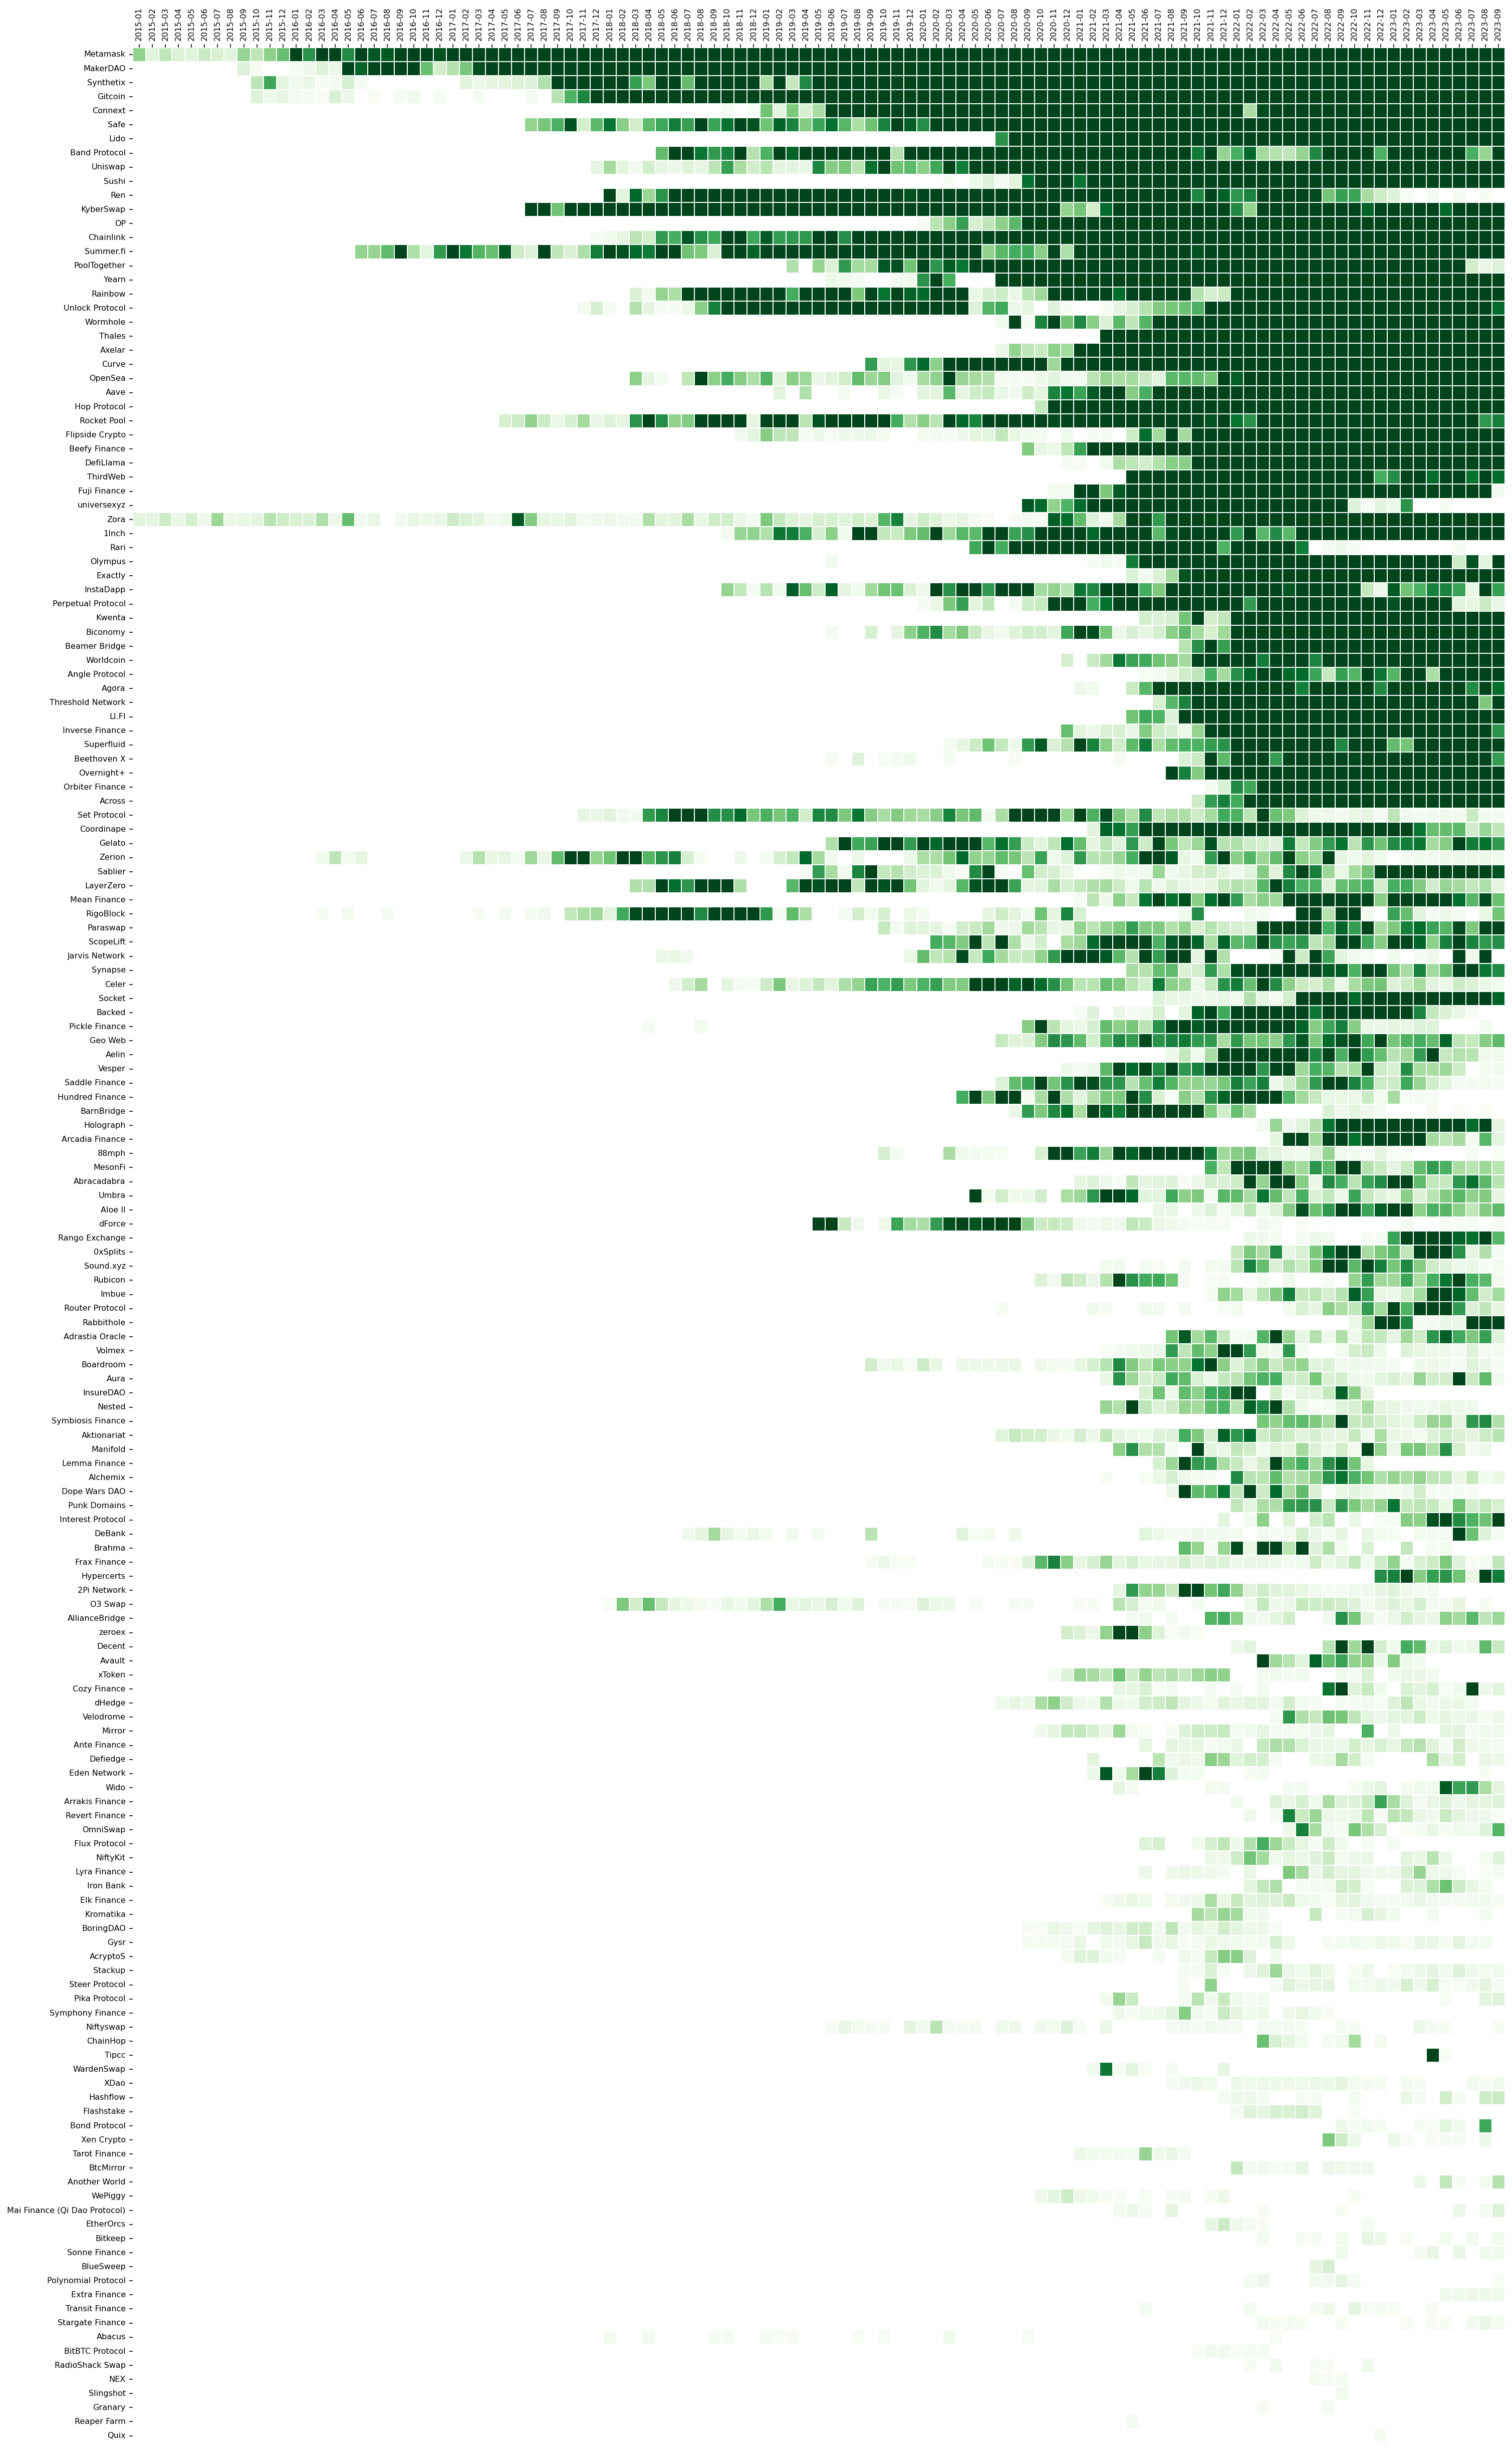

In [25]:
contribution_heatmap(
    dff[dff['project_slug'].isin(cpp['op-onchain'])],
    index_col='project_name',
    column_col='month',
    value_col='event_time',
    apply_groupby=True,
    vmax=100,
    sort_label_method='mean',
    dpi=DPI
)

(<Figure size 3024x4694.4 with 1 Axes>, <AxesSubplot:>)

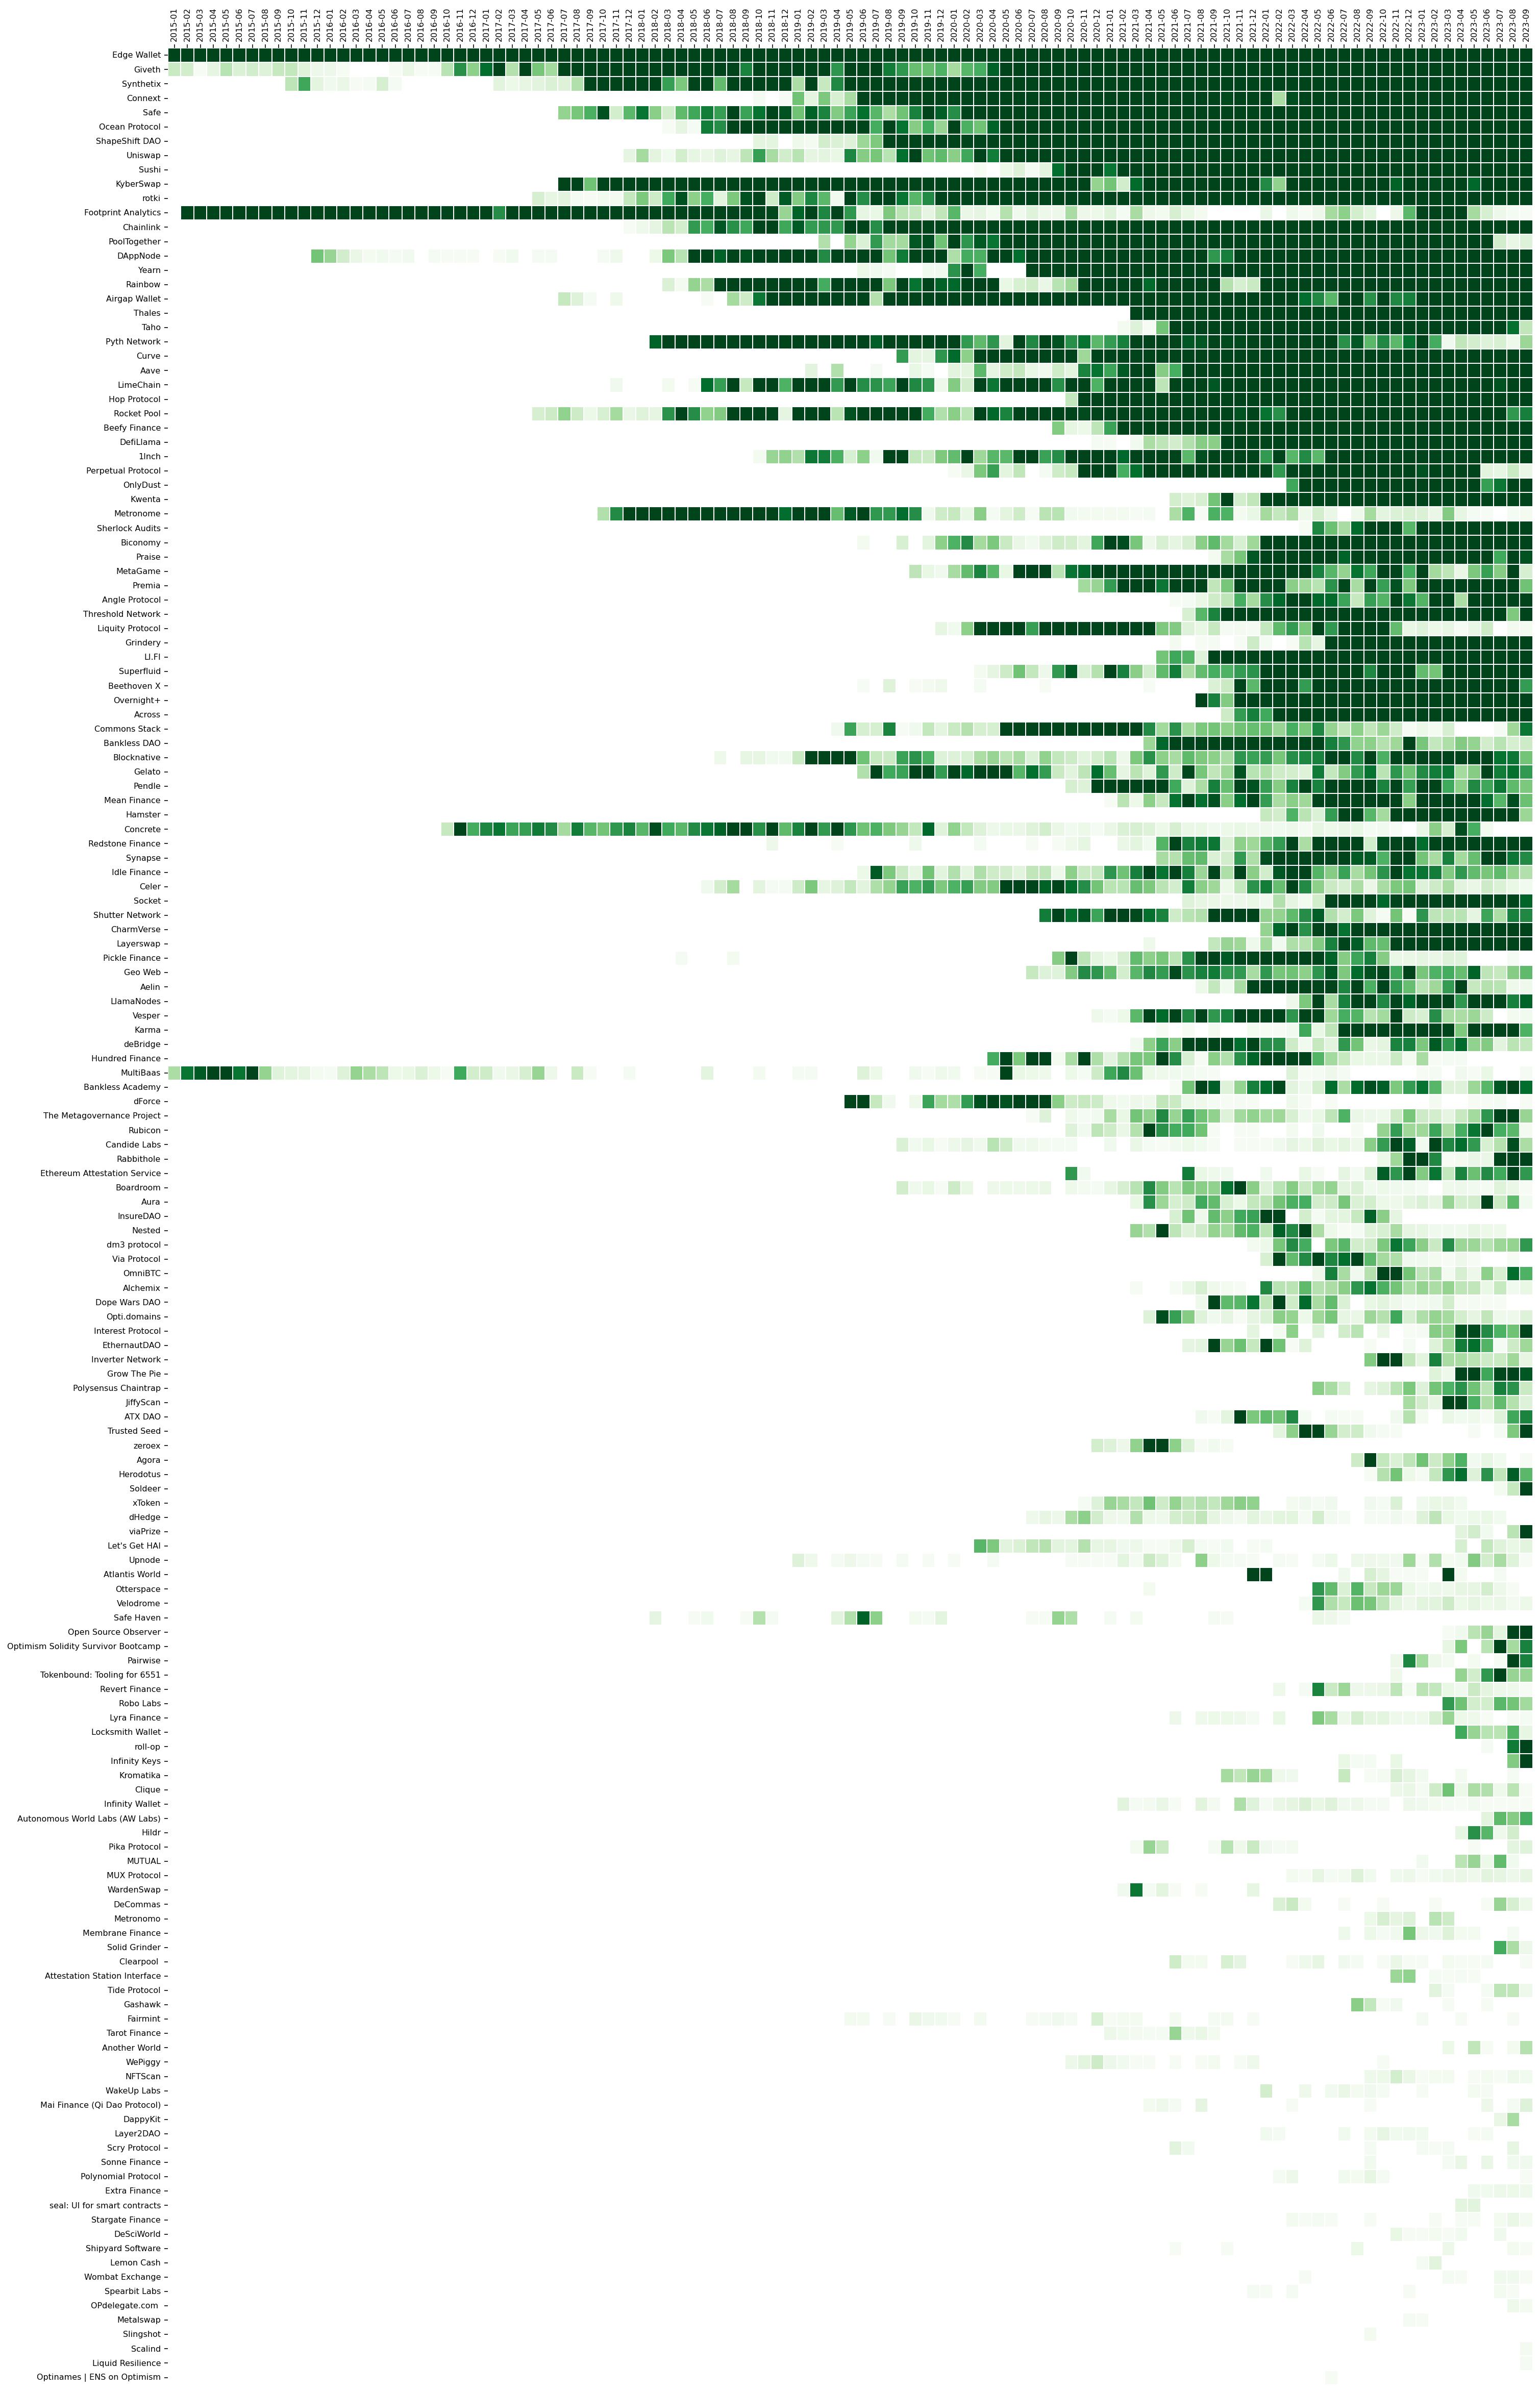

In [26]:
contribution_heatmap(
    dff[dff['project_slug'].isin(cpp['op-govgrants'])],
    index_col='project_name',
    column_col='month',
    value_col='event_time',
    apply_groupby=True,
    vmax=100,
    sort_label_method='mean',
    dpi=DPI
)

# "Leaderboard"

(<Figure size 3024x2880 with 1 Axes>, <AxesSubplot:>)

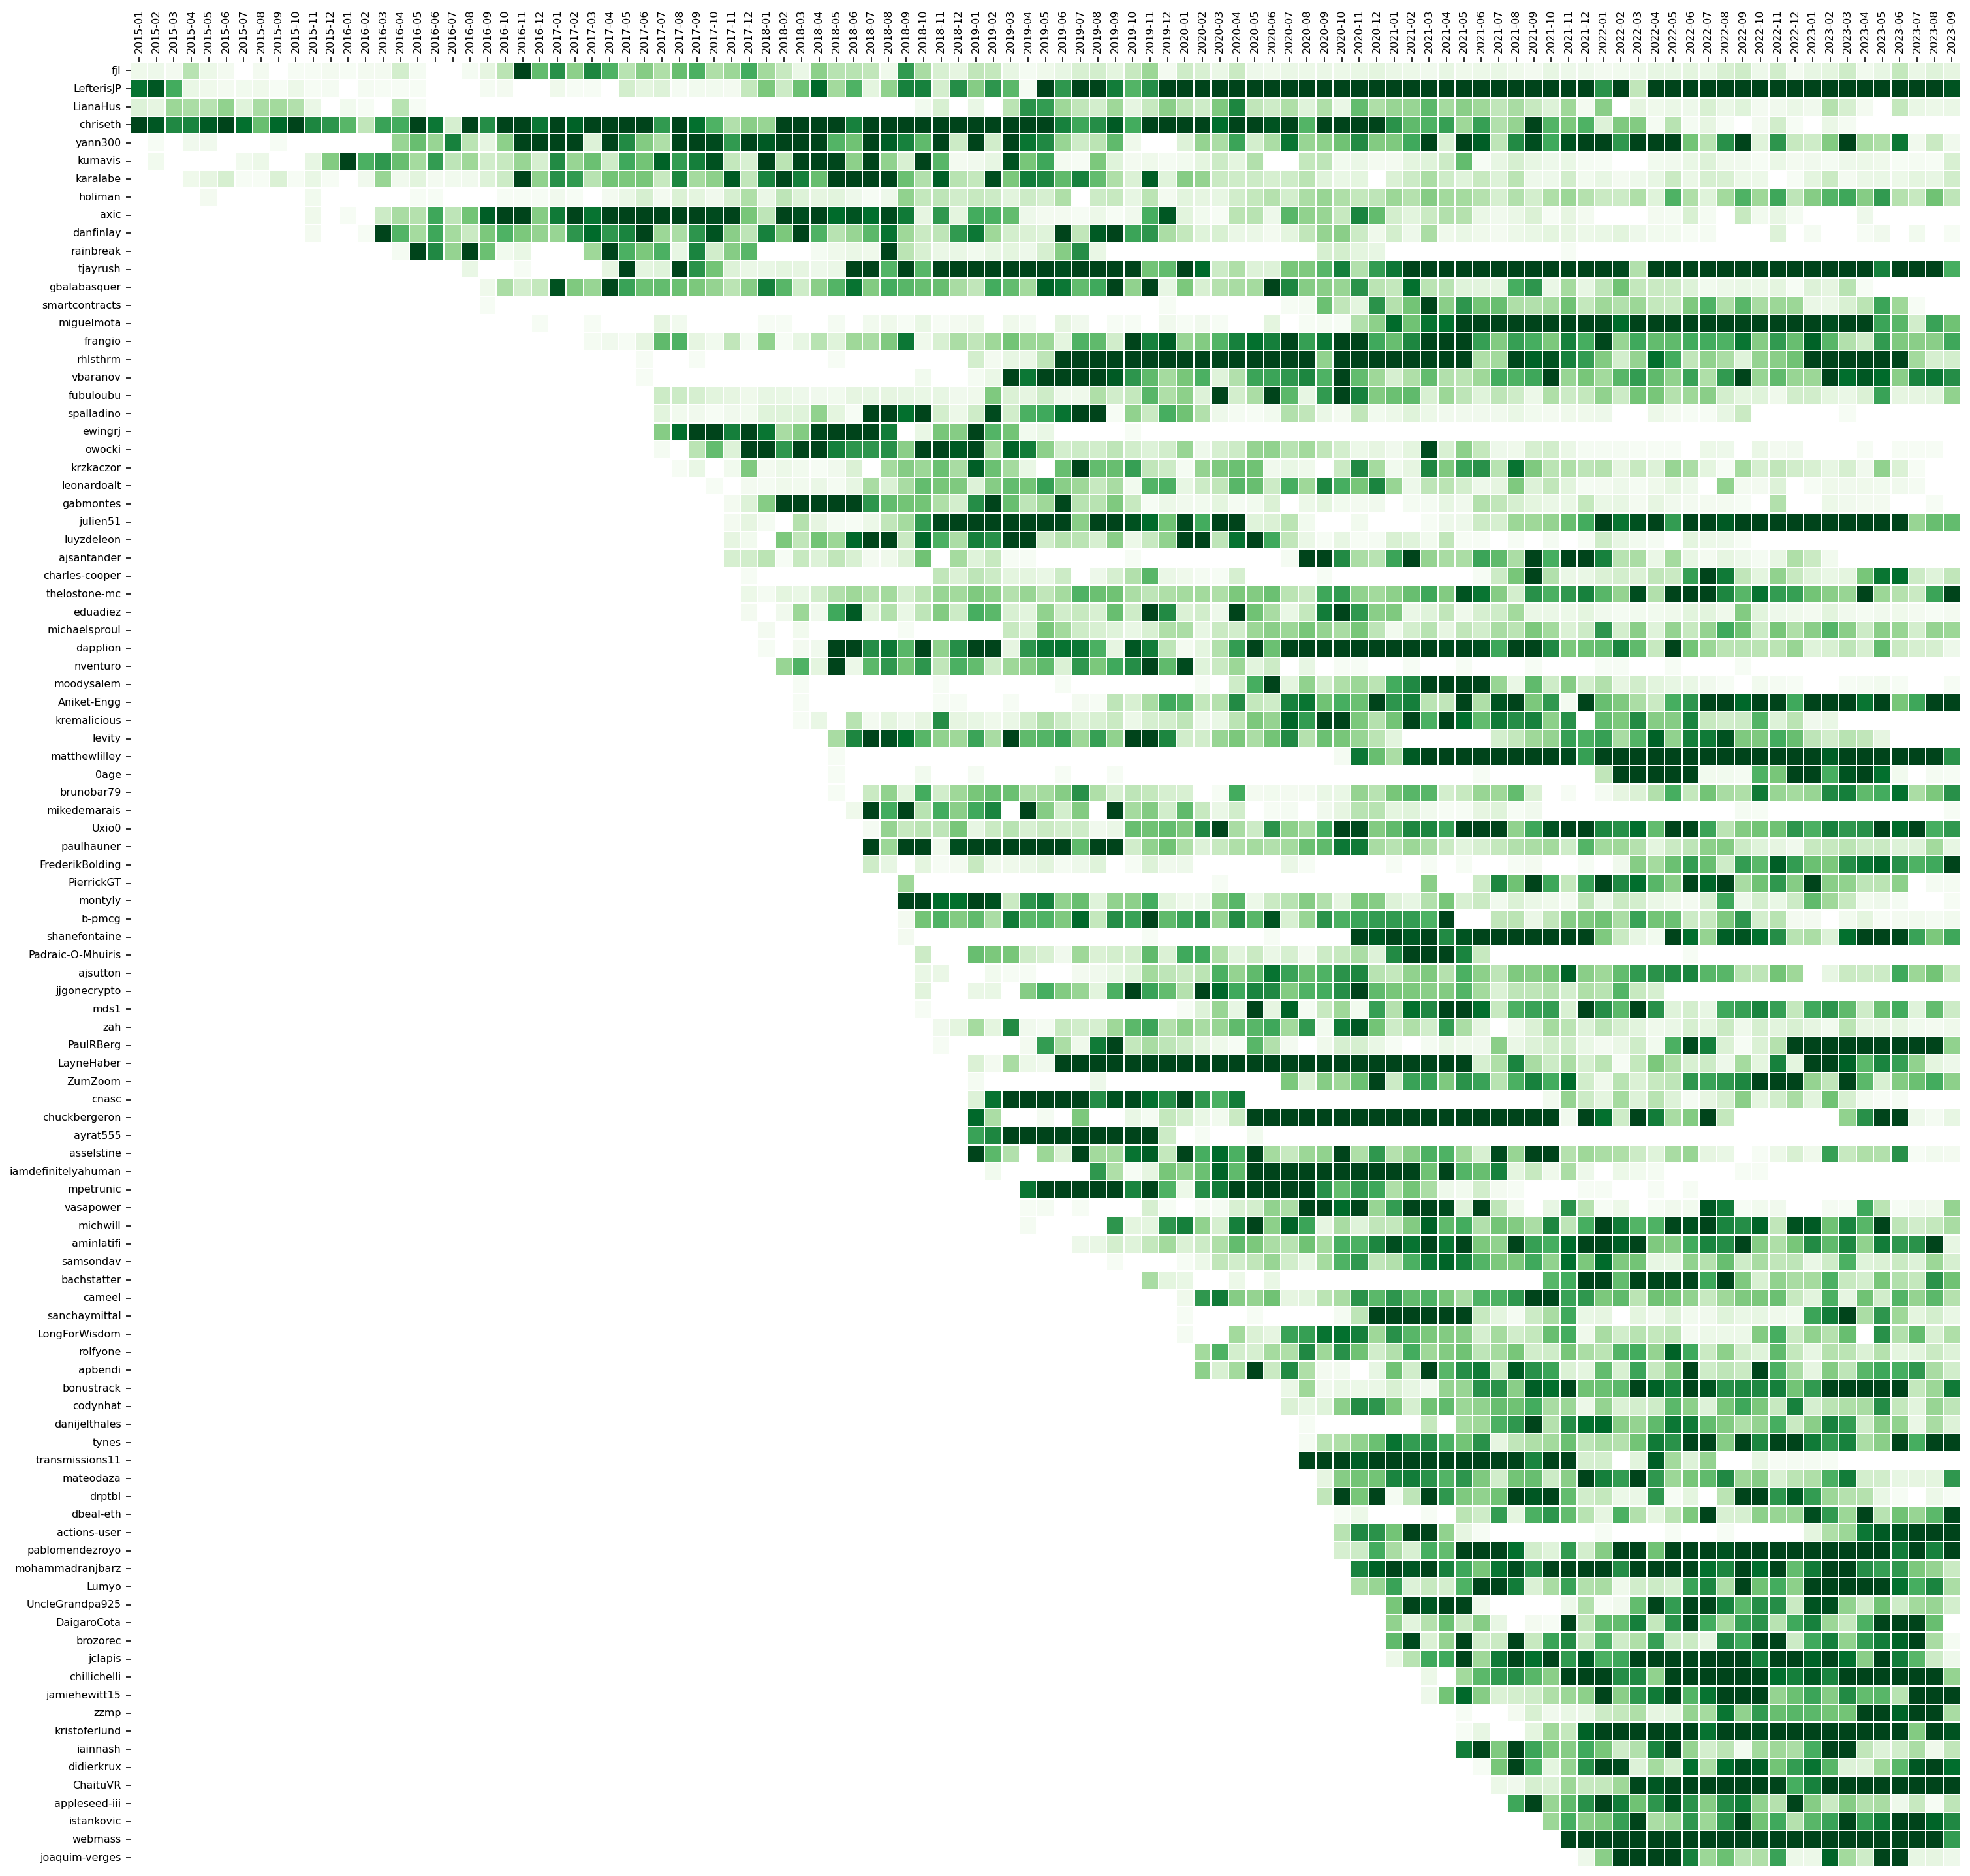

In [27]:
num_projects_contributed_to = 3
eligible_contribs = dff.groupby('contributor_name')['project_slug'].nunique()
eligible_contribs = eligible_contribs[eligible_contribs >= num_projects_contributed_to].index

top_contribs = dff[dff['contributor_name'].isin(eligible_contribs)]['contributor_name'].value_counts()
top_contribs = top_contribs.head(100).index
top_contribs = [c for c in top_contribs if "@" not in c]

contribution_heatmap(
    dff[dff.contributor_name.isin(top_contribs)],
    index_col='contributor_name',
    column_col='month',
    value_col='event_time',
    apply_groupby=True,
    vmax=100,
    dpi=DPI
)

(<Figure size 1440x1440 with 1 Axes>,
 <AxesSubplot:title={'center':'Projects with Common Contributors'}>)

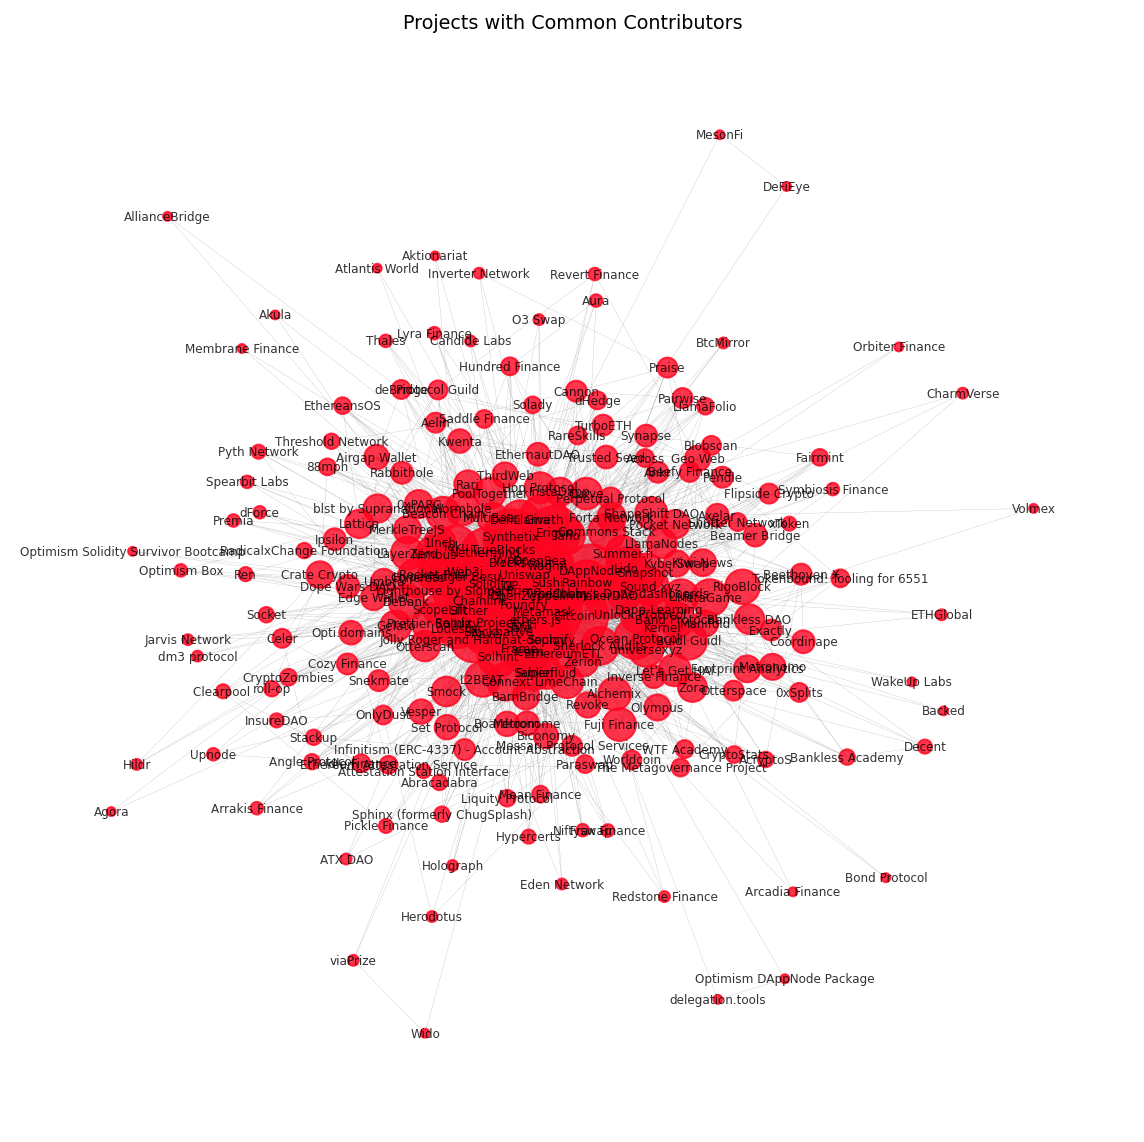

In [28]:
nodes, edges = github_network_graph(dff)
network_graph(
    nodes, edges, 
    figsize=(10,10), # looks best at (30,30)
    dpi=DPI,         # looks best at 500
    scale=1, 
    k=(3/(len(nodes)**.5)),
    min_degree=2,
    styling=dict(
        with_labels=True, 
        font_size=6, 
        font_color='black', 
        node_color='#FF0420', 
        alpha=.8,
        edge_color='grey',
        width=.1
    )
)